In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'reinclude'     : ['t1t2'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 4,
    'dropout'       : 0.75,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_075_1024_512_256_128_0001_MSE_4_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(792888, 828)
(792888, 1)
validation
(101248, 828)
(101248, 1)
test
(100432, 828)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/793 [..............................] - ETA: 14:46 - loss: 0.3338 - STD: 1.2188e-04 - MAE: 0.5696

 11/793 [..............................] - ETA: 4s - loss: 0.0612 - STD: 2.9178e-04 - MAE: 0.1837   

 19/793 [..............................] - ETA: 4s - loss: 0.0487 - STD: 1.7103e-04 - MAE: 0.1693

 28/793 [>.............................] - ETA: 4s - loss: 0.0407 - STD: 1.2118e-04 - MAE: 0.1542

 32/793 [>.............................] - ETA: 16s - loss: 0.0373 - STD: 1.1020e-04 - MAE: 0.1451

 43/793 [>.............................] - ETA: 13s - loss: 0.0305 - STD: 9.0976e-05 - MAE: 0.1300

 52/793 [>.............................] - ETA: 11s - loss: 0.0268 - STD: 7.7919e-05 - MAE: 0.1206

 60/793 [=>............................] - ETA: 10s - loss: 0.0246 - STD: 6.8937e-05 - MAE: 0.1146

 69/793 [=>............................] - ETA: 9s - loss: 0.0226 - STD: 6.1532e-05 - MAE: 0.1096 

 78/793 [=>............................] - ETA: 8s - loss: 0.0210 - STD: 5.5470e-05 - MAE: 0.1057

 86/793 [==>...........................] - ETA: 8s - loss: 0.0199 - STD: 5.1190e-05 - MAE: 0.1027

 95/793 [==>...........................] - ETA: 7s - loss: 0.0189 - STD: 4.7207e-05 - MAE: 0.1003

104/793 [==>...........................] - ETA: 7s - loss: 0.0181 - STD: 4.3899e-05 - MAE: 0.0982

113/793 [===>..........................] - ETA: 7s - loss: 0.0174 - STD: 4.1128e-05 - MAE: 0.0964

122/793 [===>..........................] - ETA: 6s - loss: 0.0168 - STD: 3.8702e-05 - MAE: 0.0948

130/793 [===>..........................] - ETA: 6s - loss: 0.0163 - STD: 3.6888e-05 - MAE: 0.0936

138/793 [====>.........................] - ETA: 6s - loss: 0.0159 - STD: 3.5369e-05 - MAE: 0.0926

147/793 [====>.........................] - ETA: 6s - loss: 0.0155 - STD: 3.3835e-05 - MAE: 0.0916

156/793 [====>.........................] - ETA: 5s - loss: 0.0152 - STD: 3.2474e-05 - MAE: 0.0906

165/793 [=====>........................] - ETA: 5s - loss: 0.0148 - STD: 3.1369e-05 - MAE: 0.0898

174/793 [=====>........................] - ETA: 5s - loss: 0.0146 - STD: 3.0395e-05 - MAE: 0.0891

183/793 [=====>........................] - ETA: 5s - loss: 0.0143 - STD: 2.9507e-05 - MAE: 0.0884

191/793 [======>.......................] - ETA: 5s - loss: 0.0141 - STD: 2.8913e-05 - MAE: 0.0879

200/793 [======>.......................] - ETA: 5s - loss: 0.0139 - STD: 2.8428e-05 - MAE: 0.0874

209/793 [======>.......................] - ETA: 4s - loss: 0.0137 - STD: 2.8126e-05 - MAE: 0.0868

218/793 [=======>......................] - ETA: 4s - loss: 0.0135 - STD: 2.7968e-05 - MAE: 0.0864

227/793 [=======>......................] - ETA: 4s - loss: 0.0133 - STD: 2.7958e-05 - MAE: 0.0860

235/793 [=======>......................] - ETA: 4s - loss: 0.0132 - STD: 2.8105e-05 - MAE: 0.0856

243/793 [========>.....................] - ETA: 4s - loss: 0.0131 - STD: 2.8431e-05 - MAE: 0.0853

252/793 [========>.....................] - ETA: 4s - loss: 0.0129 - STD: 2.9009e-05 - MAE: 0.0849

261/793 [========>.....................] - ETA: 4s - loss: 0.0128 - STD: 2.9909e-05 - MAE: 0.0846

270/793 [=========>....................] - ETA: 4s - loss: 0.0127 - STD: 3.1095e-05 - MAE: 0.0843

278/793 [=========>....................] - ETA: 4s - loss: 0.0126 - STD: 3.2437e-05 - MAE: 0.0840

286/793 [=========>....................] - ETA: 3s - loss: 0.0125 - STD: 3.4170e-05 - MAE: 0.0838

294/793 [==========>...................] - ETA: 3s - loss: 0.0124 - STD: 3.6373e-05 - MAE: 0.0836

303/793 [==========>...................] - ETA: 3s - loss: 0.0123 - STD: 3.9453e-05 - MAE: 0.0833

312/793 [==========>...................] - ETA: 3s - loss: 0.0122 - STD: 4.3356e-05 - MAE: 0.0831

320/793 [===========>..................] - ETA: 3s - loss: 0.0121 - STD: 4.7867e-05 - MAE: 0.0829

329/793 [===========>..................] - ETA: 3s - loss: 0.0120 - STD: 5.4241e-05 - MAE: 0.0827

337/793 [===========>..................] - ETA: 3s - loss: 0.0120 - STD: 6.1443e-05 - MAE: 0.0825

346/793 [============>.................] - ETA: 3s - loss: 0.0119 - STD: 7.1803e-05 - MAE: 0.0823

355/793 [============>.................] - ETA: 3s - loss: 0.0118 - STD: 8.5454e-05 - MAE: 0.0821

364/793 [============>.................] - ETA: 3s - loss: 0.0118 - STD: 1.0291e-04 - MAE: 0.0819

373/793 [=============>................] - ETA: 3s - loss: 0.0117 - STD: 1.2697e-04 - MAE: 0.0818

381/793 [=============>................] - ETA: 3s - loss: 0.0117 - STD: 1.5497e-04 - MAE: 0.0816

389/793 [=============>................] - ETA: 3s - loss: 0.0116 - STD: 1.9200e-04 - MAE: 0.0815

398/793 [==============>...............] - ETA: 2s - loss: 0.0115 - STD: 2.4824e-04 - MAE: 0.0814

407/793 [==============>...............] - ETA: 2s - loss: 0.0115 - STD: 3.2785e-04 - MAE: 0.0812

416/793 [==============>...............] - ETA: 2s - loss: 0.0114 - STD: 4.3718e-04 - MAE: 0.0810

425/793 [===============>..............] - ETA: 2s - loss: 0.0114 - STD: 5.9131e-04 - MAE: 0.0808

434/793 [===============>..............] - ETA: 2s - loss: 0.0113 - STD: 8.0971e-04 - MAE: 0.0807

442/793 [===============>..............] - ETA: 2s - loss: 0.0112 - STD: 0.0011 - MAE: 0.0805    

451/793 [================>.............] - ETA: 2s - loss: 0.0112 - STD: 0.0015 - MAE: 0.0803

460/793 [================>.............] - ETA: 2s - loss: 0.0111 - STD: 0.0019 - MAE: 0.0801

469/793 [================>.............] - ETA: 2s - loss: 0.0110 - STD: 0.0025 - MAE: 0.0798

478/793 [=================>............] - ETA: 2s - loss: 0.0110 - STD: 0.0031 - MAE: 0.0796

486/793 [=================>............] - ETA: 2s - loss: 0.0109 - STD: 0.0037 - MAE: 0.0794

494/793 [=================>............] - ETA: 2s - loss: 0.0108 - STD: 0.0042 - MAE: 0.0792

503/793 [==================>...........] - ETA: 2s - loss: 0.0108 - STD: 0.0048 - MAE: 0.0789

512/793 [==================>...........] - ETA: 1s - loss: 0.0107 - STD: 0.0054 - MAE: 0.0787

521/793 [==================>...........] - ETA: 1s - loss: 0.0106 - STD: 0.0061 - MAE: 0.0784

529/793 [===================>..........] - ETA: 1s - loss: 0.0106 - STD: 0.0066 - MAE: 0.0781

537/793 [===================>..........] - ETA: 1s - loss: 0.0105 - STD: 0.0072 - MAE: 0.0779

546/793 [===================>..........] - ETA: 1s - loss: 0.0104 - STD: 0.0079 - MAE: 0.0776

555/793 [===================>..........] - ETA: 1s - loss: 0.0104 - STD: 0.0086 - MAE: 0.0773

564/793 [====================>.........] - ETA: 1s - loss: 0.0103 - STD: 0.0093 - MAE: 0.0769

573/793 [====================>.........] - ETA: 1s - loss: 0.0102 - STD: 0.0100 - MAE: 0.0766

582/793 [=====================>........] - ETA: 1s - loss: 0.0101 - STD: 0.0107 - MAE: 0.0763

590/793 [=====================>........] - ETA: 1s - loss: 0.0101 - STD: 0.0113 - MAE: 0.0760

599/793 [=====================>........] - ETA: 1s - loss: 0.0100 - STD: 0.0120 - MAE: 0.0757

608/793 [======================>.......] - ETA: 1s - loss: 0.0099 - STD: 0.0127 - MAE: 0.0754

617/793 [======================>.......] - ETA: 1s - loss: 0.0099 - STD: 0.0134 - MAE: 0.0751

626/793 [======================>.......] - ETA: 1s - loss: 0.0098 - STD: 0.0140 - MAE: 0.0748

634/793 [======================>.......] - ETA: 1s - loss: 0.0097 - STD: 0.0146 - MAE: 0.0745

642/793 [=======================>......] - ETA: 1s - loss: 0.0097 - STD: 0.0152 - MAE: 0.0743

651/793 [=======================>......] - ETA: 0s - loss: 0.0096 - STD: 0.0159 - MAE: 0.0740

660/793 [=======================>......] - ETA: 0s - loss: 0.0095 - STD: 0.0165 - MAE: 0.0737

668/793 [========================>.....] - ETA: 0s - loss: 0.0095 - STD: 0.0170 - MAE: 0.0734

677/793 [========================>.....] - ETA: 0s - loss: 0.0094 - STD: 0.0176 - MAE: 0.0731

685/793 [========================>.....] - ETA: 0s - loss: 0.0093 - STD: 0.0182 - MAE: 0.0728

693/793 [=========================>....] - ETA: 0s - loss: 0.0093 - STD: 0.0187 - MAE: 0.0726

702/793 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 0.0193 - MAE: 0.0723

711/793 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 0.0198 - MAE: 0.0720

720/793 [==========================>...] - ETA: 0s - loss: 0.0091 - STD: 0.0204 - MAE: 0.0718

729/793 [==========================>...] - ETA: 0s - loss: 0.0091 - STD: 0.0209 - MAE: 0.0715

736/793 [==========================>...] - ETA: 0s - loss: 0.0090 - STD: 0.0213 - MAE: 0.0714

744/793 [===========================>..] - ETA: 0s - loss: 0.0090 - STD: 0.0218 - MAE: 0.0711

753/793 [===========================>..] - ETA: 0s - loss: 0.0089 - STD: 0.0223 - MAE: 0.0709

762/793 [===========================>..] - ETA: 0s - loss: 0.0089 - STD: 0.0228 - MAE: 0.0706

771/793 [============================>.] - ETA: 0s - loss: 0.0088 - STD: 0.0234 - MAE: 0.0704

780/793 [============================>.] - ETA: 0s - loss: 0.0088 - STD: 0.0239 - MAE: 0.0701

788/793 [============================>.] - ETA: 0s - loss: 0.0087 - STD: 0.0243 - MAE: 0.0699

793/793 [==============================] - 7s 8ms/step - loss: 0.0087 - STD: 0.0246 - MAE: 0.0698 - val_loss: 0.0044 - val_STD: 0.0470 - val_MAE: 0.0473


Epoch 2/10000


  1/793 [..............................] - ETA: 19s - loss: 0.0044 - STD: 0.0609 - MAE: 0.0473

  9/793 [..............................] - ETA: 5s - loss: 0.0043 - STD: 0.0672 - MAE: 0.0489 

 17/793 [..............................] - ETA: 5s - loss: 0.0042 - STD: 0.0677 - MAE: 0.0488

 26/793 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0684 - MAE: 0.0483

 35/793 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0686 - MAE: 0.0480

 44/793 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0684 - MAE: 0.0485

 53/793 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0680 - MAE: 0.0488

 61/793 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0678 - MAE: 0.0489

 69/793 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0674 - MAE: 0.0491

 78/793 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0673 - MAE: 0.0492

 87/793 [==>...........................] - ETA: 4s - loss: 0.0043 - STD: 0.0672 - MAE: 0.0494

 96/793 [==>...........................] - ETA: 4s - loss: 0.0043 - STD: 0.0671 - MAE: 0.0493

105/793 [==>...........................] - ETA: 4s - loss: 0.0043 - STD: 0.0673 - MAE: 0.0492

113/793 [===>..........................] - ETA: 4s - loss: 0.0043 - STD: 0.0675 - MAE: 0.0490

121/793 [===>..........................] - ETA: 4s - loss: 0.0042 - STD: 0.0676 - MAE: 0.0489

130/793 [===>..........................] - ETA: 4s - loss: 0.0042 - STD: 0.0677 - MAE: 0.0487

139/793 [====>.........................] - ETA: 4s - loss: 0.0042 - STD: 0.0680 - MAE: 0.0486

148/793 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0682 - MAE: 0.0485

157/793 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0683 - MAE: 0.0485

166/793 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0683 - MAE: 0.0484

174/793 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0684 - MAE: 0.0483

182/793 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0685 - MAE: 0.0482

191/793 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0686 - MAE: 0.0482

200/793 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0687 - MAE: 0.0481

209/793 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0689 - MAE: 0.0481

218/793 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0690 - MAE: 0.0480

226/793 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0690 - MAE: 0.0480

235/793 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0690 - MAE: 0.0480

244/793 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0689 - MAE: 0.0481

253/793 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0689 - MAE: 0.0481

262/793 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0689 - MAE: 0.0480

271/793 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0690 - MAE: 0.0479

280/793 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0691 - MAE: 0.0478

288/793 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0692 - MAE: 0.0478

297/793 [==========>...................] - ETA: 3s - loss: 0.0041 - STD: 0.0694 - MAE: 0.0477

306/793 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0694 - MAE: 0.0477

315/793 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0695 - MAE: 0.0476

324/793 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0696 - MAE: 0.0475

332/793 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0697 - MAE: 0.0475

341/793 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0474

350/793 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0473

359/793 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0473

368/793 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0472

377/793 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0472

385/793 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0471

394/793 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0471

403/793 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0471

412/793 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0470

421/793 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0470

430/793 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0469

438/793 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0469

447/793 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0705 - MAE: 0.0469

456/793 [================>.............] - ETA: 2s - loss: 0.0039 - STD: 0.0705 - MAE: 0.0468

465/793 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0706 - MAE: 0.0468

474/793 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0707 - MAE: 0.0467

483/793 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0707 - MAE: 0.0467

491/793 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0708 - MAE: 0.0467

500/793 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0466

509/793 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0466

518/793 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0467

527/793 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0467

536/793 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0466

544/793 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0466

553/793 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0466

562/793 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0466

571/793 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0465

580/793 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0465

589/793 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0465

597/793 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0465

606/793 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0464

615/793 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0464

624/793 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0464

633/793 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0463

642/793 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0463

651/793 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0462

660/793 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0714 - MAE: 0.0462

669/793 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0715 - MAE: 0.0462

678/793 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0716 - MAE: 0.0461

687/793 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0716 - MAE: 0.0461

696/793 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0717 - MAE: 0.0461

705/793 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0717 - MAE: 0.0461

714/793 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0718 - MAE: 0.0460

723/793 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0718 - MAE: 0.0460

732/793 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0718 - MAE: 0.0460

741/793 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0460

750/793 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0460

759/793 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0459

768/793 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0459

776/793 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0459

785/793 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0458

793/793 [==============================] - 5s 6ms/step - loss: 0.0038 - STD: 0.0721 - MAE: 0.0458 - val_loss: 0.0032 - val_STD: 0.0611 - val_MAE: 0.0431


Epoch 3/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0037 - STD: 0.0802 - MAE: 0.0469

  9/793 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0438 

 17/793 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

 26/793 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0434

 35/793 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0435

 44/793 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0436

 53/793 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0435

 61/793 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

 70/793 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

 78/793 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

 87/793 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436

 96/793 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0437

105/793 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0437

113/793 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

121/793 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

130/793 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

139/793 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0437

148/793 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

157/793 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

166/793 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

174/793 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

183/793 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

192/793 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

201/793 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

210/793 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

219/793 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

227/793 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

236/793 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

245/793 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

254/793 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

263/793 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

272/793 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

280/793 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

289/793 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

298/793 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

307/793 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

316/793 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

325/793 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

334/793 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

342/793 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

351/793 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

360/793 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

369/793 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

378/793 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

386/793 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

395/793 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

404/793 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

413/793 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

422/793 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

431/793 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

439/793 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

447/793 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

456/793 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

465/793 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

474/793 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

483/793 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

491/793 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

500/793 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

508/793 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

517/793 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

526/793 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

535/793 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

543/793 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

552/793 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

561/793 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

570/793 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

579/793 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

588/793 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

596/793 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

605/793 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

614/793 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

623/793 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

632/793 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0434

640/793 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

648/793 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

657/793 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

666/793 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

675/793 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

684/793 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

693/793 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

701/793 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

709/793 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

718/793 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

727/793 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

736/793 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

745/793 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

752/793 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

761/793 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

770/793 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

779/793 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

788/793 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

793/793 [==============================] - 5s 6ms/step - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432 - val_loss: 0.0029 - val_STD: 0.0636 - val_MAE: 0.0396


Epoch 4/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0037 - STD: 0.0803 - MAE: 0.0445

  9/793 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0436 

 17/793 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

 25/793 [..............................] - ETA: 5s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

 34/793 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0426

 43/793 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

 52/793 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0774 - MAE: 0.0425

 61/793 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0425

 69/793 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0425

 78/793 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0769 - MAE: 0.0428

 87/793 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0768 - MAE: 0.0428

 96/793 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0767 - MAE: 0.0427

105/793 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

113/793 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

121/793 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

130/793 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

139/793 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

148/793 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

157/793 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

165/793 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

174/793 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

183/793 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

192/793 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

201/793 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

210/793 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

218/793 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

227/793 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

235/793 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

244/793 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

253/793 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

261/793 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

269/793 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

278/793 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

287/793 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

295/793 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

304/793 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

312/793 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

320/793 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

329/793 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

338/793 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

347/793 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

356/793 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

364/793 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

373/793 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

382/793 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

391/793 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

400/793 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

408/793 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

416/793 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

425/793 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

434/793 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

443/793 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

451/793 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

459/793 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

468/793 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

477/793 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

486/793 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

495/793 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

503/793 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

512/793 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

521/793 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

530/793 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

539/793 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

548/793 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

556/793 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

565/793 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

574/793 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

583/793 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

592/793 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

601/793 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

609/793 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

618/793 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

627/793 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

636/793 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

645/793 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

654/793 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

662/793 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

671/793 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

679/793 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

688/793 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

696/793 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

705/793 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

713/793 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

722/793 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

731/793 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

740/793 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

749/793 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

757/793 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

765/793 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

774/793 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

783/793 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

792/793 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

793/793 [==============================] - 5s 7ms/step - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422 - val_loss: 0.0029 - val_STD: 0.0597 - val_MAE: 0.0384


Epoch 5/10000


  1/793 [..............................] - ETA: 18s - loss: 0.0028 - STD: 0.0785 - MAE: 0.0399

  9/793 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0409 

 18/793 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

 26/793 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

 35/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

 44/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

 53/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0411

 62/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

 71/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0412

 79/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

 88/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

 97/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

106/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

115/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

123/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

131/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

140/793 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

149/793 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

158/793 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

167/793 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

176/793 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

184/793 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

193/793 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415

202/793 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415

211/793 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

220/793 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

229/793 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

237/793 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

246/793 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

255/793 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

264/793 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

273/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

282/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

290/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

299/793 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

308/793 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

317/793 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

326/793 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

334/793 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

342/793 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

351/793 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

360/793 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

369/793 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

378/793 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

386/793 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

395/793 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

404/793 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

413/793 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

422/793 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

431/793 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

439/793 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

448/793 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

457/793 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

466/793 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

475/793 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

483/793 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

492/793 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

501/793 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

510/793 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

519/793 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

528/793 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

536/793 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

545/793 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

554/793 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

563/793 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

572/793 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

581/793 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

589/793 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

598/793 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

607/793 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

616/793 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

625/793 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

633/793 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

642/793 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

651/793 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

660/793 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

669/793 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

677/793 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

686/793 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

695/793 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

704/793 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

713/793 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

722/793 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

731/793 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

739/793 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

748/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

757/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

766/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

775/793 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

784/793 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0413

792/793 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

793/793 [==============================] - 5s 6ms/step - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414 - val_loss: 0.0030 - val_STD: 0.0572 - val_MAE: 0.0390


Epoch 6/10000


  1/793 [..............................] - ETA: 19s - loss: 0.0026 - STD: 0.0751 - MAE: 0.0380

  9/793 [..............................] - ETA: 5s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0408 

 18/793 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0773 - MAE: 0.0403

 26/793 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0401

 35/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0403

 44/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0404

 52/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0403

 61/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0403

 70/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

 78/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0403

 87/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0402

 96/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

104/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

112/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

121/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

130/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

139/793 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

148/793 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

156/793 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

165/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

174/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

183/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

192/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

201/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

209/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

218/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

227/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

235/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

244/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

252/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

261/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

270/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

279/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

288/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

297/793 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

305/793 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

314/793 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

323/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

332/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

341/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

349/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

358/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0406

367/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0406

376/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0406

385/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0406

394/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

402/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

411/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

420/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

429/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

438/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

447/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

455/793 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

464/793 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

473/793 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

481/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

490/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

499/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

507/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

515/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

524/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

533/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

542/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

551/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

560/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

568/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

577/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

586/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

595/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

604/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

612/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

620/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

629/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

638/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

647/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

656/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

664/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

672/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

681/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

689/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

698/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

707/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

715/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

723/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

731/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

739/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

748/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

757/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

765/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

773/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

782/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

791/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

793/793 [==============================] - 5s 7ms/step - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405 - val_loss: 0.0028 - val_STD: 0.0615 - val_MAE: 0.0380


Epoch 7/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0028 - STD: 0.0805 - MAE: 0.0392

  9/793 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0796 - MAE: 0.0399 

 18/793 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0793 - MAE: 0.0399

 26/793 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

 34/793 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0398

 42/793 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

 51/793 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

 60/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0399

 69/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

 77/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

 85/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0400

 94/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0400

103/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

112/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

121/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

129/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0400

137/793 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0400

146/793 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0400

155/793 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0399

164/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0399

173/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

181/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

189/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

198/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

207/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

216/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

225/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

233/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

242/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

251/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

260/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

269/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

277/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0399

285/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0399

294/793 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0399

303/793 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0399

312/793 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0399

321/793 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0399

329/793 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

337/793 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

346/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

355/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

364/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

373/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

382/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

390/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

399/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

408/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

417/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

426/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

434/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

442/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

450/793 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

459/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

468/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

477/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

485/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

494/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

503/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

512/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

521/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

530/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

538/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

546/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

555/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

564/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

573/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

582/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

591/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

599/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

608/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

617/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

625/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

634/793 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

642/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

650/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

659/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

668/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

677/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

686/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

694/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

703/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

712/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

721/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

729/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

737/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

745/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

754/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

763/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

772/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

780/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

788/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

793/793 [==============================] - 5s 7ms/step - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397 - val_loss: 0.0030 - val_STD: 0.0577 - val_MAE: 0.0387


Epoch 8/10000


  1/793 [..............................] - ETA: 16s - loss: 0.0031 - STD: 0.0762 - MAE: 0.0397

  9/793 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0398 

 18/793 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0397

 27/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

 36/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

 45/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0399

 54/793 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0398

 62/793 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0398

 71/793 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

 79/793 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

 88/793 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0395

 96/793 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0395

105/793 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0396

113/793 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0396

122/793 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0395

131/793 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0395

140/793 [====>.........................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0395

149/793 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0395

157/793 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0395

165/793 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

174/793 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

183/793 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

192/793 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

201/793 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

210/793 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

218/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

226/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

235/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

244/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

253/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

262/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

270/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

278/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

287/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

296/793 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

304/793 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

313/793 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

321/793 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

329/793 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

338/793 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

347/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

356/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

364/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

372/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

381/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

390/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

399/793 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

408/793 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

417/793 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

425/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

434/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

443/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

452/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

460/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

469/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

477/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

486/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

495/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

504/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

513/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

521/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

529/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

538/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

547/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

556/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

565/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

573/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

581/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

590/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

598/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

607/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

616/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

624/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

632/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

641/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

650/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

659/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

668/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

677/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

685/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

694/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

703/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

712/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

721/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

729/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

737/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

746/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

755/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

763/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

771/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

779/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

788/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

793/793 [==============================] - 5s 7ms/step - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393 - val_loss: 0.0029 - val_STD: 0.0614 - val_MAE: 0.0379


Epoch 9/10000


  1/793 [..............................] - ETA: 19s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0392

  8/793 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0391 

 16/793 [..............................] - ETA: 5s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0388

 25/793 [..............................] - ETA: 5s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0387

 33/793 [>.............................] - ETA: 5s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

 41/793 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0387

 49/793 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

 58/793 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

 67/793 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0387

 76/793 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

 84/793 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0387

 93/793 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0387

102/793 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

111/793 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

120/793 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0388

129/793 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0388

137/793 [====>.........................] - ETA: 4s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0388

145/793 [====>.........................] - ETA: 4s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0388

154/793 [====>.........................] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0388

163/793 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

172/793 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0387

180/793 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0388

188/793 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0388

196/793 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0388

205/793 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0388

214/793 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

223/793 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

232/793 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

240/793 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

248/793 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

257/793 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

266/793 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

274/793 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

282/793 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0388

290/793 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

299/793 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

308/793 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

317/793 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

326/793 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

335/793 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

343/793 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0390

352/793 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

360/793 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

369/793 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

378/793 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

387/793 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

395/793 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

404/793 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

413/793 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

422/793 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

431/793 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

439/793 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

447/793 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

456/793 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

465/793 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

474/793 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

483/793 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

491/793 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

500/793 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

509/793 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

518/793 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

527/793 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

535/793 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

544/793 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

553/793 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

562/793 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

571/793 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

580/793 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

588/793 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

596/793 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

605/793 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

614/793 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

623/793 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

632/793 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

640/793 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

648/793 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

657/793 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

666/793 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

675/793 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

684/793 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

692/793 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

700/793 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

709/793 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

718/793 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

726/793 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

735/793 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

744/793 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

752/793 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

761/793 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

770/793 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

779/793 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

787/793 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

793/793 [==============================] - 5s 7ms/step - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388 - val_loss: 0.0029 - val_STD: 0.0643 - val_MAE: 0.0381


Epoch 10/10000


  1/793 [..............................] - ETA: 19s - loss: 0.0030 - STD: 0.0829 - MAE: 0.0386

  9/793 [..............................] - ETA: 5s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387 

 18/793 [..............................] - ETA: 5s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0385

 27/793 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0805 - MAE: 0.0386

 36/793 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

 45/793 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

 53/793 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

 62/793 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

 71/793 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0387

 80/793 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0386

 89/793 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0386

 97/793 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

105/793 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

114/793 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0384

123/793 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0383

132/793 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0383

141/793 [====>.........................] - ETA: 4s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0382

149/793 [====>.........................] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0382

157/793 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0382

166/793 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

175/793 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0381

184/793 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

193/793 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0381

201/793 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

210/793 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0381

219/793 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

228/793 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

236/793 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

245/793 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

253/793 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

262/793 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

271/793 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

280/793 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

289/793 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

297/793 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

306/793 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

315/793 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

324/793 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

333/793 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

342/793 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

350/793 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

359/793 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

368/793 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

377/793 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

386/793 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

394/793 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

402/793 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

411/793 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

420/793 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

429/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

438/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

446/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

455/793 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

464/793 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

473/793 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

482/793 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

490/793 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

499/793 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

508/793 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

517/793 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

526/793 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

535/793 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

543/793 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

552/793 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

560/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

569/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

578/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

586/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

594/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

603/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

612/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

620/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

629/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

637/793 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

646/793 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

655/793 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

664/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

673/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

681/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

689/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

698/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

707/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

716/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

724/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

732/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

741/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

750/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

759/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

768/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

776/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

784/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

793/793 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

793/793 [==============================] - 5s 7ms/step - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382 - val_loss: 0.0027 - val_STD: 0.0592 - val_MAE: 0.0371


Epoch 11/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0025 - STD: 0.0783 - MAE: 0.0382

 10/793 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0786 - MAE: 0.0386 

 19/793 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0792 - MAE: 0.0383

 28/793 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0379

 37/793 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0379

 45/793 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0379

 53/793 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0379

 62/793 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0377

 71/793 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0376

 80/793 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0377

 89/793 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0376

 97/793 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0376

106/793 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0376

115/793 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0376

124/793 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0376

133/793 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0376

141/793 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0376

150/793 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

159/793 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

168/793 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0377

177/793 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0377

186/793 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

194/793 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

203/793 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

212/793 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

221/793 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

230/793 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

238/793 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

247/793 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

256/793 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

265/793 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

274/793 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

282/793 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

291/793 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

300/793 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

309/793 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

318/793 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

327/793 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

335/793 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

344/793 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

353/793 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

362/793 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

371/793 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

380/793 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

388/793 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

397/793 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

406/793 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

415/793 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

423/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

432/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

440/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

448/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

456/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

465/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

474/793 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

483/793 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

492/793 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

501/793 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

510/793 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

519/793 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

528/793 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

537/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

546/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

554/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

562/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

571/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

579/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

588/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

597/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

605/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

613/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

621/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

630/793 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

639/793 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

648/793 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

656/793 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

665/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

674/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

683/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

692/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

700/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

707/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

716/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

725/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

734/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

743/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

752/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

760/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

769/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

778/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

787/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

793/793 [==============================] - 5s 6ms/step - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375 - val_loss: 0.0027 - val_STD: 0.0682 - val_MAE: 0.0380


Epoch 12/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0025 - STD: 0.0853 - MAE: 0.0368

  9/793 [..............................] - ETA: 5s - loss: 0.0026 - STD: 0.0817 - MAE: 0.0371 

 18/793 [..............................] - ETA: 5s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0368

 26/793 [..............................] - ETA: 5s - loss: 0.0026 - STD: 0.0814 - MAE: 0.0369

 35/793 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

 44/793 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0369

 52/793 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0369

 61/793 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

 70/793 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

 78/793 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

 86/793 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

 94/793 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

102/793 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

111/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0370

119/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0370

128/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0371

136/793 [====>.........................] - ETA: 4s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0372

144/793 [====>.........................] - ETA: 4s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0372

153/793 [====>.........................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

162/793 [=====>........................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

171/793 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

180/793 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

188/793 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

197/793 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

206/793 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0373

215/793 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

224/793 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

232/793 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

240/793 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

249/793 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

258/793 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

267/793 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

276/793 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

284/793 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

293/793 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

301/793 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

310/793 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

319/793 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

327/793 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

336/793 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

345/793 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

353/793 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0372

361/793 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

369/793 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

377/793 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

386/793 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

395/793 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

404/793 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

412/793 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

420/793 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

428/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

437/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

446/793 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

455/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

464/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

472/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

480/793 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

488/793 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

496/793 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

505/793 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

514/793 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

523/793 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

531/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

539/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

548/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

557/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

566/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

575/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

583/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

591/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

599/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

607/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

616/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

625/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

633/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

642/793 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

651/793 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

660/793 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

669/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

677/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

685/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

693/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

702/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

710/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

719/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

727/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

735/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

743/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

752/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

761/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

768/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

776/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

783/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

791/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

793/793 [==============================] - 5s 7ms/step - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373 - val_loss: 0.0028 - val_STD: 0.0620 - val_MAE: 0.0384


Epoch 13/10000


  1/793 [..............................] - ETA: 18s - loss: 0.0025 - STD: 0.0784 - MAE: 0.0371

  9/793 [..............................] - ETA: 5s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0367 

 18/793 [..............................] - ETA: 5s - loss: 0.0026 - STD: 0.0801 - MAE: 0.0372

 27/793 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0373

 35/793 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0372

 44/793 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0371

 52/793 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0372

 60/793 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0372

 69/793 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0372

 78/793 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0373

 86/793 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0373

 95/793 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

104/793 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

112/793 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

121/793 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

130/793 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0373

139/793 [====>.........................] - ETA: 4s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0373

148/793 [====>.........................] - ETA: 4s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0372

157/793 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

165/793 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

174/793 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0371

183/793 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0371

192/793 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0370

201/793 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0370

210/793 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0370

218/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

227/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

236/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

245/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

254/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

263/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

272/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

281/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

290/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

299/793 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

308/793 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

316/793 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

325/793 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

334/793 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

343/793 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

352/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

361/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

369/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

378/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

387/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

396/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

405/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

413/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

422/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

431/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

440/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

449/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

458/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

466/793 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

475/793 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

483/793 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

492/793 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

501/793 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

509/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

517/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

526/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

535/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

544/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

553/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

561/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

570/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

579/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

588/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

597/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

606/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

614/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

623/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

631/793 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

640/793 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

649/793 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

658/793 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

666/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

675/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

684/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

693/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

702/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

711/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

719/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

727/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

736/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

745/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

754/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

762/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

770/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

779/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

788/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

793/793 [==============================] - 5s 6ms/step - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369 - val_loss: 0.0027 - val_STD: 0.0633 - val_MAE: 0.0374


Epoch 14/10000


  1/793 [..............................] - ETA: 18s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0356

 10/793 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.0804 - MAE: 0.0369 

 18/793 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.0811 - MAE: 0.0364

 26/793 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.0814 - MAE: 0.0362

 34/793 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0813 - MAE: 0.0361

 43/793 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0814 - MAE: 0.0361

 52/793 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0814 - MAE: 0.0363

 61/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

 70/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0363

 78/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0363

 86/793 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0363

 95/793 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0362

104/793 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0363

113/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0363

122/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0363

130/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0363

138/793 [====>.........................] - ETA: 4s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0363

147/793 [====>.........................] - ETA: 4s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0363

156/793 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0364

165/793 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0821 - MAE: 0.0364

173/793 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0821 - MAE: 0.0364

181/793 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0820 - MAE: 0.0364

190/793 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0820 - MAE: 0.0364

199/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0363

208/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0363

217/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0363

225/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0363

234/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0363

243/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0363

252/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0820 - MAE: 0.0364

261/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0364

269/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

278/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

287/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0364

296/793 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

305/793 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0364

314/793 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

322/793 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

330/793 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

339/793 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

347/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

355/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

364/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

373/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

381/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

389/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

398/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

407/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

416/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

425/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

433/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

442/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

450/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

459/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

468/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

476/793 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

484/793 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

492/793 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

501/793 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

509/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

518/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

526/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

535/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

544/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

551/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

560/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

568/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

576/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

585/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

594/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

603/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

612/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

620/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

629/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

638/793 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

647/793 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

656/793 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

665/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

673/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

682/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

690/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

699/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

708/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

717/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

725/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

733/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

742/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

751/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

760/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

769/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

777/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

785/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

793/793 [==============================] - 5s 7ms/step - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364 - val_loss: 0.0029 - val_STD: 0.0669 - val_MAE: 0.0400


Epoch 15/10000


  1/793 [..............................] - ETA: 19s - loss: 0.0026 - STD: 0.0889 - MAE: 0.0380

  9/793 [..............................] - ETA: 5s - loss: 0.0025 - STD: 0.0837 - MAE: 0.0370 

 18/793 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0366

 27/793 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0365

 36/793 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0362

 44/793 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0363

 52/793 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0363

 61/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0363

 69/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0364

 78/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0364

 87/793 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0364

 95/793 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0364

103/793 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0363

111/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0363

119/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0363

127/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0362

136/793 [====>.........................] - ETA: 4s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0362

144/793 [====>.........................] - ETA: 4s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0362

153/793 [====>.........................] - ETA: 4s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0362

161/793 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0362

169/793 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0363

178/793 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0363

187/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

195/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0363

204/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

213/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0363

222/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0363

231/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0363

239/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0364

246/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0364

254/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

262/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

270/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0364

279/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

288/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

296/793 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0363

304/793 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

313/793 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

322/793 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

331/793 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0364

340/793 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

348/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

356/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

365/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

374/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

383/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

392/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

400/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

409/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

418/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

427/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

436/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

444/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

452/793 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

460/793 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

469/793 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

478/793 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

486/793 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

495/793 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

503/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

512/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

521/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

528/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0363

537/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0363

545/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0363

553/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

561/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0363

569/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0363

578/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0363

587/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0363

595/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0363

604/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0363

613/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0363

622/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

631/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

639/793 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

647/793 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

655/793 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

664/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

673/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

682/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0362

690/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0362

698/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0362

707/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

716/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

725/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

733/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

741/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

750/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

759/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

768/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

777/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

785/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

793/793 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

793/793 [==============================] - 5s 7ms/step - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362 - val_loss: 0.0028 - val_STD: 0.0667 - val_MAE: 0.0393


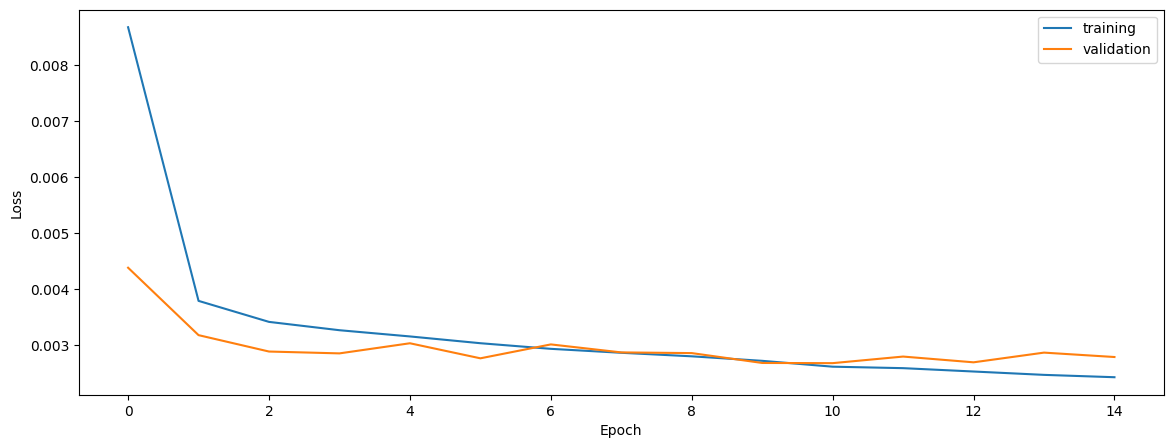

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.8527212821992087
0.8338281499992157
0.8263185487290623


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

normalized
0.853357823881943
0.8514264451771899
0.8310482167124972


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

native
0.8518162567154626
0.8486486111178388
0.8266058252398909


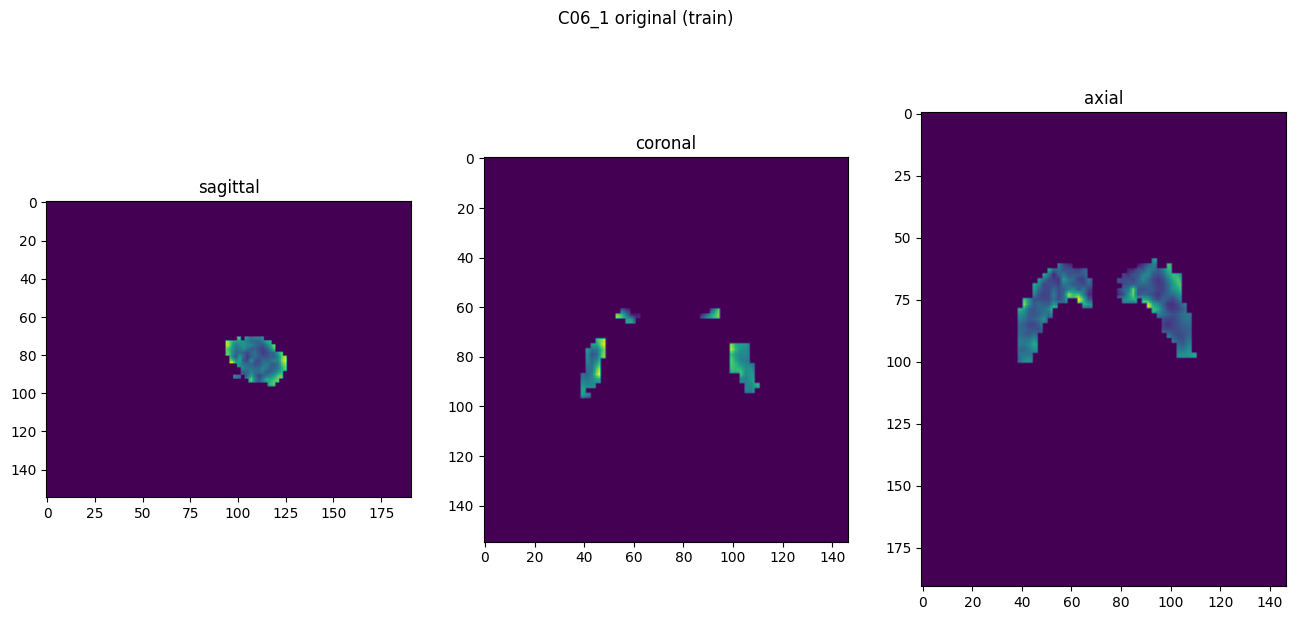

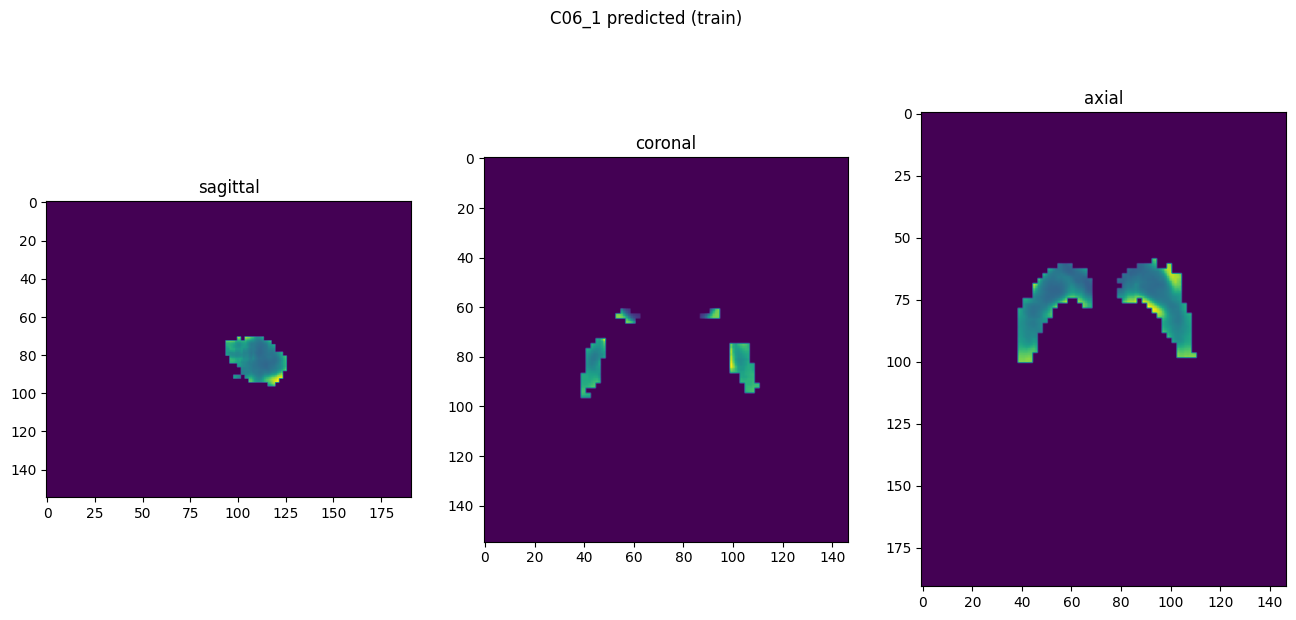

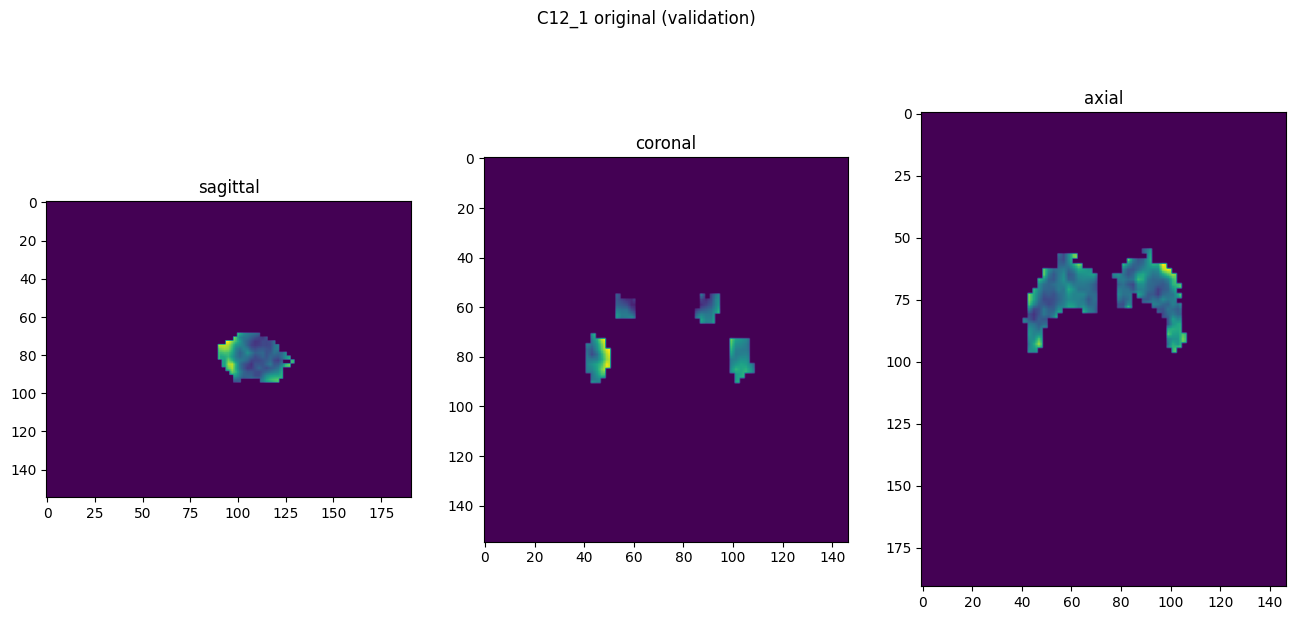

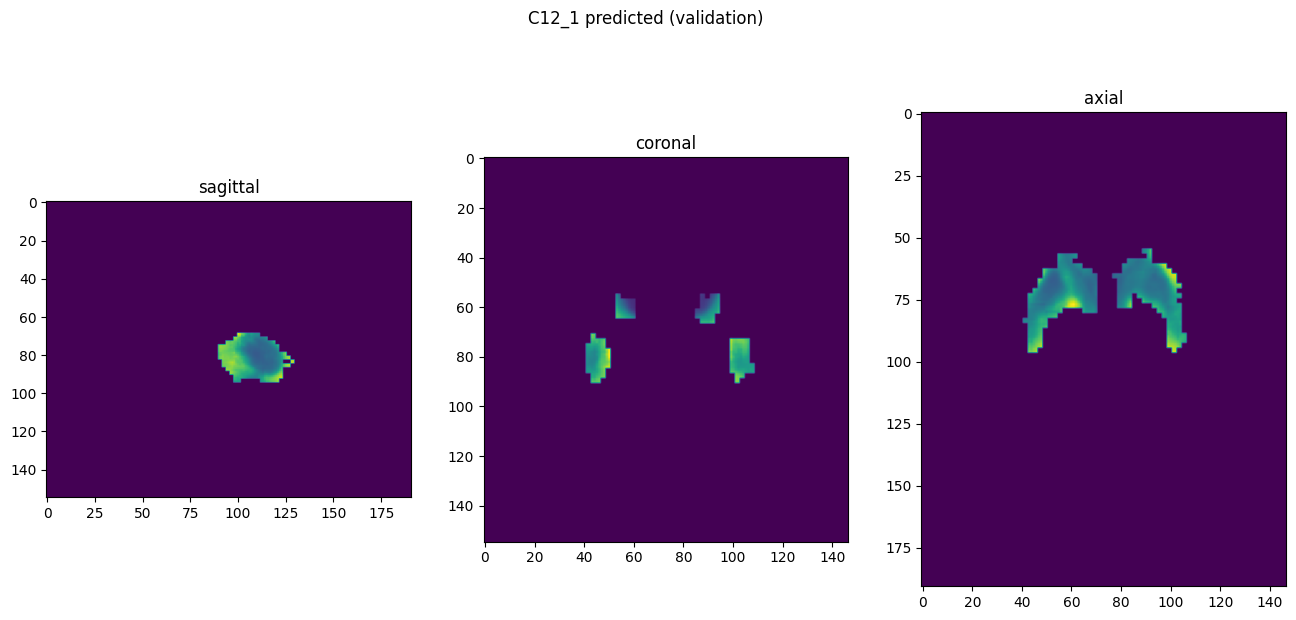

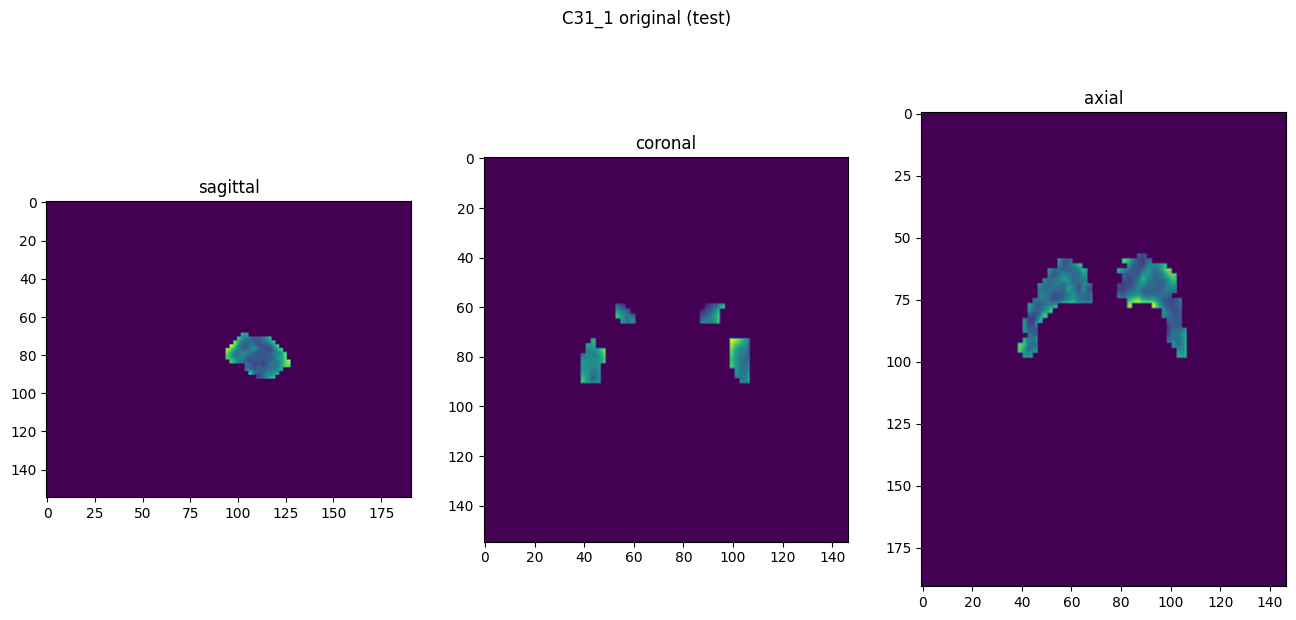

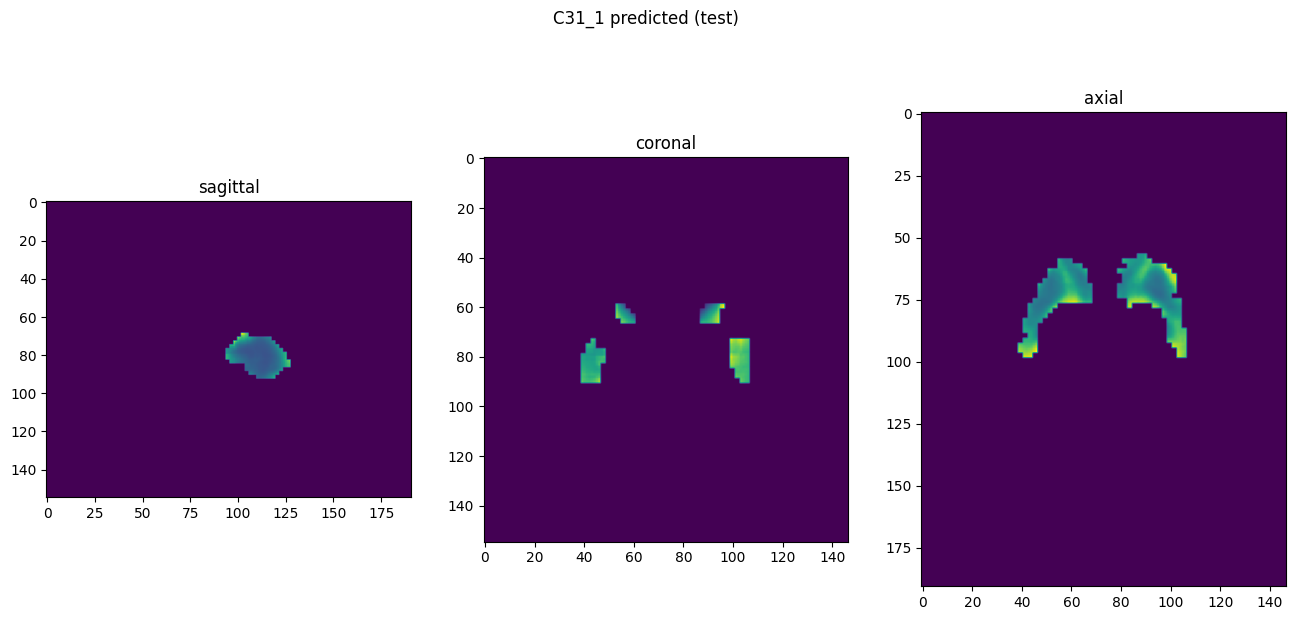

In [10]:
showResults(model, gen, threshold=None, background=False)